# Bayesian parameter estimation of Montbrio Model

The aim of this work is to infer the parameter of single Montbrio model using HMC sampling.

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
from scipy import stats as spstats
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import pystan
from parse_csv import parse_csv2
from read_csvs import read_samples

In [4]:
import sbi.utils as utils

from Similaritymetrics import Rmse_metric, canberra_metric

In [5]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
cwd = os.getcwd()
cwd

'/data/MPR_NMM_SBI_HMC'

In [9]:
Res_dir='/Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform' 

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $



In [10]:
def Montbrio_model(v0, r0, delta, eta, J, I_input, dt, sigma):
    vs, rs = [v0], [r0]
    nsteps=len(I_input)
    for i in range(nsteps-1):
        v, r = vs[-1], rs[-1]
        dr =(delta/np.pi) +2*r*v
        dv = v**2  -(np.pi*r)**2 + J*r+ eta +I_input[i]
        rs.append(r + dt * dr +sqrt(dt) *sigma * randn())
        vs.append(v + dt * dv +sqrt(dt) *sigma * randn())
    v,r = np.array(vs), np.array(rs)
    return v,r

In [11]:
def plot_nullcline(ax, delta, eta, J, I0, linewidth=3, style='--',  vmin=-20,vmax=20):
    v = np.linspace(vmin,vmax,100000)
    nullcline_v=-delta/(2*np.pi*v)
    nullcline_r=v**2  -(np.pi*(-delta/(2*np.pi*v)))**2 + J*(-delta/(2*np.pi*v))+ eta +I0
    ax.plot(v, nullcline_v , style, color='red', linewidth=linewidth)
    ax.plot(v, nullcline_r , style, color='blue', linewidth=linewidth)

In [12]:
def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

In [13]:
def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="blue", alpha=0.9)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="red", alpha=0.9)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

# Load data input 

In [14]:
data_iput_filename=str('data_input_mpr_sd1')

In [15]:
data_input = dict(load(cwd+str(Res_dir)+'/data_input_files/'+ str(data_iput_filename)+ '.R.npz'))
#data = pystan.read_rdump('data.R')

In [16]:
data_input

{'I0': array(3.),
 'I_input': array([0., 0., 0., ..., 0., 0., 0.]),
 'J_true': array(14.5),
 'alpha_true': array(-6.57142857),
 'beta_true': array(17.33081484),
 'delta_true': array(0.7),
 'dt': array(0.01),
 'eta_true': array(-4.6),
 'nd': array([], dtype=float64),
 'nt': array(10000),
 'r_init': array(0.5),
 'rlim': array([0., 8.]),
 'rs': array([0.5       , 0.46314734, 0.44556643, ..., 0.06189788, 0.0568664 ,
        0.05660491]),
 'sigma': array(0.1),
 't0': array(0.),
 't_final': array(100.),
 't_off': array(60.),
 't_on': array(30.),
 'ts': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
        9.999e+01]),
 'v_init': array(-3.),
 'vlim': array([-8.,  8.]),
 'vs': array([-3.        , -2.91089229, -2.82616582, ..., -1.97729356,
        -1.97561742, -1.96184262])}

In [17]:
nt=data_input['nt']
dt=data_input['dt']
t_init=data_input['t0']
t_final=data_input['t_final']
ts=data_input['ts']

vs=data_input['vs']
rs=data_input['rs']

v0=data_input['v_init']
r0=data_input['r_init']

I_input=data_input['I_input']


delta_true=data_input['delta_true']
eta_true=data_input['eta_true']
J_true=data_input['J_true']
alpha_true=data_input['alpha_true']
beta_true=data_input['beta_true']

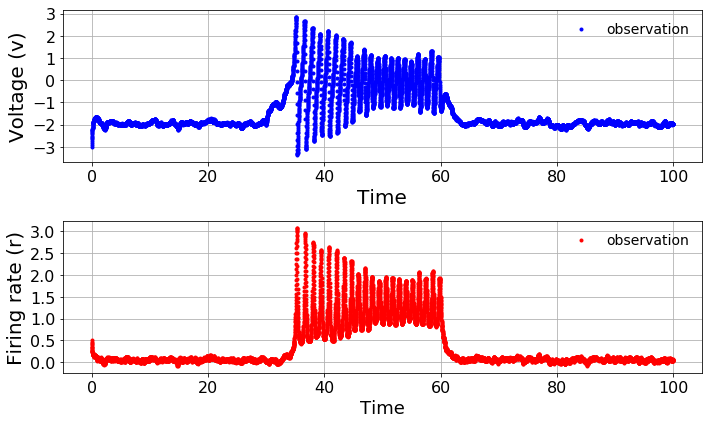

In [18]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, vs, '.', color='blue', label='observation')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Voltage (v)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, loc='upper right',fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, rs, '.', color='red',label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate (r)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, loc='upper right', fontsize=14)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"MPR_NMM_HMC_SDE_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"MPR_NMM_HMC_SDE_obs1.eps"), doi=800)
plt.show()

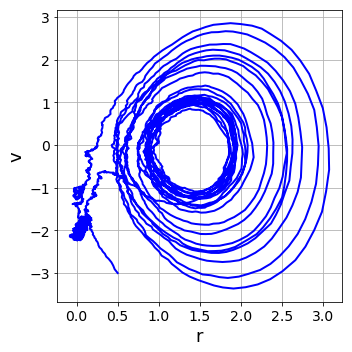

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(rs, vs, 'b', linewidth=2)
plt.xlabel('r', fontsize=18); plt.ylabel('v', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()
plt.show()

# Now lets infer the parameters delta, alpha, beta, with truncated uniform prior.

In [20]:
cwd = os.getcwd()
curr_dir=cwd
curr_dir

'/data/MPR_NMM_SBI_HMC'

In [21]:
model=str('MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform')

In [22]:
!cat $model'.stan'

data {
    int nt;
    real dt;
    real r_init;
    real v_init;
    real rlim[2];
    real vlim[2];
    vector[nt] rs;
    vector[nt] vs;
    vector[nt] I_input;
}

transformed data {
    real std_prior=0.1;
}

parameters {
    vector<lower=rlim[1], upper=rlim[2]>[nt] r;
    vector<lower=vlim[1], upper=vlim[2]>[nt] v;
    real<lower=0., upper=5.> delta;
    real<lower=-15., upper=0.>  alpha;
    real<lower=0.0, upper=30.>   beta;
    real<lower=0.0> eps;
    real<lower=0.0> sig;  
}

transformed parameters {
    real eta;
    real J;
    eta=alpha*delta;
    J=beta*sqrt(delta);
}

model {

    /* priors*/
  
    eps ~ cauchy(0., 0.1);   
    sig ~ cauchy(0., 0.1); 
 

    r[1]~ normal(r_init, 0.1);
    v[1]~ normal(v_init, 0.1);

    
    /* integrate & predict */
    
    for (t in 1:(nt-1)) {
            real dr = 2*r[t]*v[t]+(delta/pi());
            real dv = v[t]*v[t] -(pi()*r[t])*(pi()*r[t]) + J*r[t]+ eta +I_input[t];
            r[t+1] ~ normal(r[t] + dt*dr, sqrt(dt)*sig); 
  

### Compile  Stan code.

compile with cmdstan

In [23]:
! cd /home/meysam/cmdstan/ && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  /data/MPR_NMM_SBI_HMC/MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform.stan --o=/data/MPR_NMM_SBI_HMC/MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform.hpp
Model name=MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_model
Input file=/data/MPR_NMM_SBI_HMC/MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform.stan
Output file=/data/MPR_NMM_SBI_HMC/MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -O3 -march=native -mtune=native -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /data/MPR_NMM_SBI_HMC/MPR_NMM_HMC_SDE_raw_

##  Run Stan code

In [ ]:
# %%bash

# del=0.80
# depth=10
# iter=10
# warm_iter=10

# alg=hmc
# model=MPR_NMM_HMC_SDE_raw_ratios_truncuniform
# data_input=data_input_mpr_sd1.R
# data_output=data_output_${alg}_${model}
# mkdir -p ${data_output}

# Data_dir='/Res_MPR_NMM_HMC_SDE_raw_ratios_truncuniform'

# log_file=report_convergence_${model}.txt

# echo "HMC started for" ${alg}_${model} >> ${log_file}

# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${iter} \
#         adapt \
#         delta=${del} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_$i.out &
# done
# #wait

# echo "HMC Finished for" ${alg}_${model} >> ${log_file}

In [24]:
%%bash

del=0.85
depth=10
iter=1000
warm_iter=1000

Res_dir='/Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform'

alg=hmc
model=MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform

data_input=data_input_mpr_sd1.R
data_output=data_output_${alg}_${model}

log_file=$PWD${Res_dir}/report_convergence_${model}.txt

echo "HMC started for" ${alg}_${model} >> ${log_file}

for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=${warm_iter} num_samples=${iter} \
        adapt \
        delta=${del} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${depth}  \
        data file=$PWD${Res_dir}/data_input_files/${data_input}\
        output file=$PWD${Res_dir}/output_${alg}_${model}_$i.csv refresh=1 \
        &> $PWD${Res_dir}/output_${alg}_${model}_$i.out &
done
#wait

echo "HMC Finished for" ${alg}_${model} >> ${log_file}

In [25]:
fit_foldername=Res_dir
#fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [26]:
dir_data_output=cwd+"/"+fit_foldername

In [27]:
!tail -n2 $dir_data_output/*$model*out

==> /data/MPR_NMM_SBI_HMC//Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform/output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_1.out <==
               5252.44 seconds (Total)


==> /data/MPR_NMM_SBI_HMC//Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform/output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_2.out <==
               5621.09 seconds (Total)


==> /data/MPR_NMM_SBI_HMC//Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform/output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_3.out <==
               5832.92 seconds (Total)


==> /data/MPR_NMM_SBI_HMC//Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform/output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_4.out <==
               5216.3 seconds (Total)



In [28]:
#%run parse_csv.py

## check the convergence 

In [29]:
chain=1

In [30]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [31]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 2000 / 2000 [100%]  (Sampling)
  Elapsed Time: 3703.86 seconds (Warm-up)
                1548.58 seconds (Sampling)
                5252.44 seconds (Total)



In [32]:
from report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

num_samples: 1000
num_warmup: 1000
save_warmup: 1
adapt_delta: 0.84999999999999998
max_depth: 10
total_time: 5252.44


In [33]:
num_samples=1000

In [34]:
from  report_diagnostics_stan import  run_summary, Nuts_plot, check_rhat, check_div, check_treedepth, check_energy, check_n_eff


In [35]:

dict_samples_diagnostics=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=1000, nsampling=num_samples,  variables_of_interest=['lp__', 'energy__', 'accept_stat__', 'divergent__', 'treedepth__', 'n_leapfrog__'  ])


In [36]:
lp__, accept_stat__, treedepth__, divergent__, energy__,  = dict_samples_diagnostics['lp__'], dict_samples_diagnostics['accept_stat__'],  dict_samples_diagnostics['treedepth__'], dict_samples_diagnostics['divergent__'], dict_samples_diagnostics['energy__']


In [37]:
check_divergence__=check_div(divergent__)
check_treedepth__=check_treedepth(treedepth__, int(10.0))
check_energy__=check_energy(energy__)

In [38]:
check_divergence__, check_treedepth__, check_energy__

(0.6, 6.6, 0.5418763921079959)

In [39]:
fit_summary=run_summary(cwd+"/", dir_data_output+"/"+str(fit_filename_csv))

fit_filefoder: Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform
fit_filename: output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_1.csv
mycsvfile: /data/MPR_NMM_SBI_HMC/Res_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform/output_hmc_MPR_NMM_HMC_SDE_raw_rv_ratios_truncuniform_1.csv
running stan summary!
finished stan summary!


In [40]:
cwd
# cd ..

'/data/MPR_NMM_SBI_HMC'

## posterior predictive density 

In [41]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [42]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (2000,)
accept_stat__ (2000,)
stepsize__ (2000,)
treedepth__ (2000,)
n_leapfrog__ (2000,)
divergent__ (2000,)
energy__ (2000,)
r (2000, 10000)
v (2000, 10000)
delta (2000,)
alpha (2000,)
beta (2000,)
eps (2000,)
sig (2000,)
eta (2000,)
J (2000,)


In [43]:
Burnin=1000
nSample=fit['lp__'].shape[0]-Burnin

In [44]:
divergent__=fit['divergent__'][-nSample:][:,newaxis]
lp__=fit['lp__'][-nSample:][:,newaxis]
n_leapfrog__=fit['n_leapfrog__'][-nSample:][:,newaxis]

In [45]:
divergent__.shape,n_leapfrog__.shape,lp__.shape

((1000, 1), (1000, 1), (1000, 1))

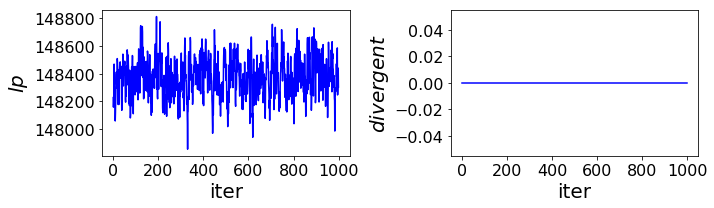

In [46]:
figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(lp__, 'b')
plt.xlabel('iter', fontsize=20)
plt.ylabel('$lp$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
tight_layout()
plt.subplot(122)
plt.plot(divergent__, 'b')
plt.xlabel('iter', fontsize=20)
plt.ylabel('$divergent$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
tight_layout()
plt.savefig(os.path.join(dir_data_output,"lp_div_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"lp_div_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [47]:
eps_est=fit['eps'][-nSample:]
sig_est=fit['sig'][-nSample:]


print("eps_est=", eps_est.mean())
print("sig_est=", sig_est.mean())

eps_est= 0.00711320079
sig_est= 0.0762896416


In [48]:

r_est=fit['r']
v_est=fit['v']

r_est_mean=mean(r_est[-nSample:],axis=0)
v_est_mean=mean(v_est[-nSample:],axis=0)

#r_est_reg=mean((fit['amplitude'][-nSample:][:,newaxis])*(fit['r'][-nSample:])+(fit['offset'][-nSample:][:,newaxis]),axis=0)
#v_est_reg=mean((fit['amplitude'][-nSample:][:,newaxis])*(fit['v'][-nSample:])+(fit['offset'][-nSample:][:,newaxis]),axis=0)

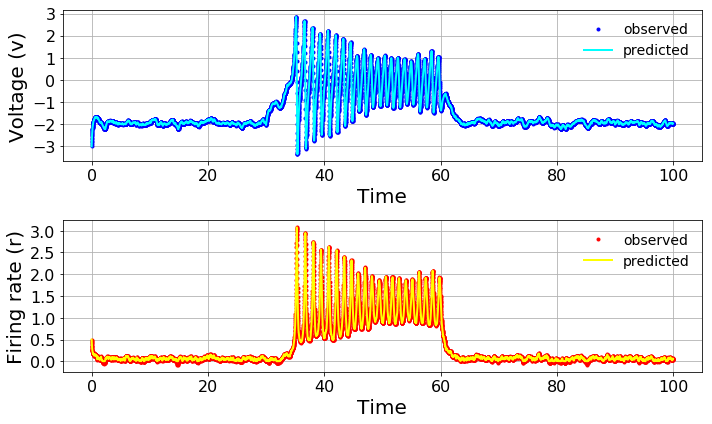

In [49]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, vs, '.', color='blue', label='observed')
plt.plot(ts, v_est_mean, lw=2, color='cyan', label='predicted')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Voltage (v)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, loc='upper right',fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, rs, '.', color='red',label='observed')
plt.plot(ts, r_est_mean, lw=2, color='yellow', label='predicted')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Firing rate (r)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(frameon=False, loc='upper right', fontsize=14)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(dir_data_output,"Fitted_obs1_"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Fitted_obs1_"+str(model)+"_chain_"+str(chain)+".png"), doi=800)
plt.show()

In [50]:
r_est_lo, r_est_hi = percentile(r_est, [5, 95], axis=0)
v_est_lo, v_est_hi = percentile(v_est, [5, 95], axis=0)

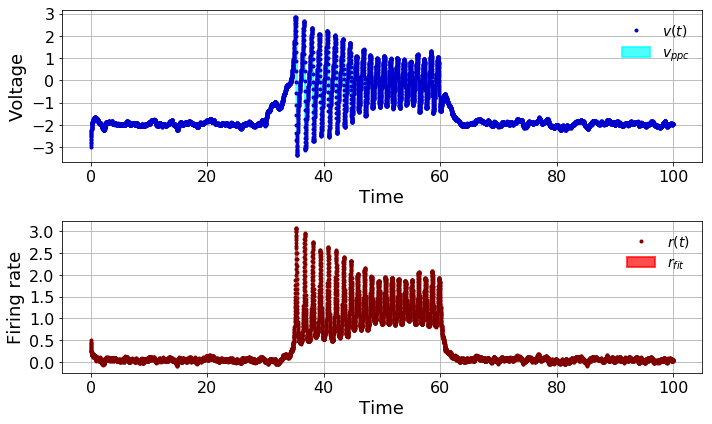

In [51]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, vs, '.', color='mediumblue', linewidth=1., label='$v(t)$')
fill_between(ts, v_est_lo, v_est_hi, linewidth=2, alpha=0.7, facecolor='cyan', edgecolor='cyan',  label='$v_{ppc}$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, rs, '.', color='maroon', label='$r(t)$')
fill_between(ts, r_est_lo, r_est_hi, linewidth=2, alpha=0.7, facecolor='red', edgecolor='red',  label='$r_{fit}$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(dir_data_output,"Fitted_ppc_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Fitted_ppc_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [52]:
rs.shape, r_est_mean.shape

((10000,), (10000,))

In [53]:
RMSE=0.5*(Rmse_metric(rs, r_est_mean)+Rmse_metric(vs, v_est_mean))
print("RMSE=", RMSE)

RMSE= 0.005081236193236121


In [54]:
params_label=np.array(['delta', 'alpha', 'beta'])
params_label=np.array(['$\Delta$', '$alpha$', '$beta$'])

In [55]:
delta_est=fit['delta'][-nSample:]
alpha_est=fit['alpha'][-nSample:]
beta_est=fit['beta'][-nSample:]
eta_est=fit['eta'][-nSample:]
J_est=fit['J'][-nSample:]

In [56]:
print("delta_est=", delta_est.mean())
print("alpha_est=", alpha_est.mean())
print("beta_est=", beta_est.mean())

delta_est= 0.698682669
alpha_est= -6.60461543
beta_est= 17.3591852


In [57]:
posterior_samples=np.array([delta_est, alpha_est, beta_est]).T
posterior_samples.shape

(1000, 3)

In [58]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_obs1.npy' ) , posterior_samples)

In [59]:
true_params = np.array([delta_true, alpha_true, beta_true])

In [60]:
params_est_mean=np.array([delta_est.mean(), alpha_est.mean(), beta_est.mean()])

In [61]:
print("params_true=[delta, alpha, beta]=", true_params)
print("params_est=[delta_est, alpha_est, beta_est]=", params_est_mean)

params_true=[delta, alpha, beta]= [ 0.7        -6.57142857 17.33081484]
params_est=[delta_est, alpha_est, beta_est]= [ 0.69868267 -6.60461543 17.3591852 ]


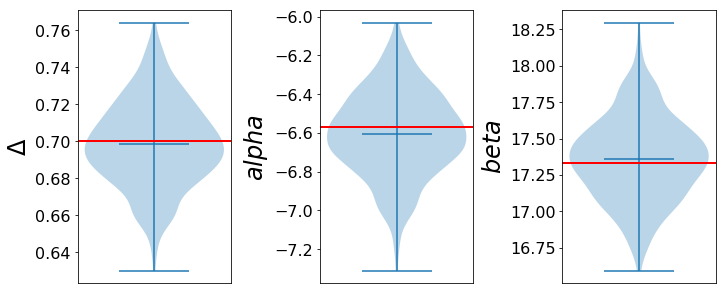

In [62]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, alpha_est, beta_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig(os.path.join(dir_data_output,"Posteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Posteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

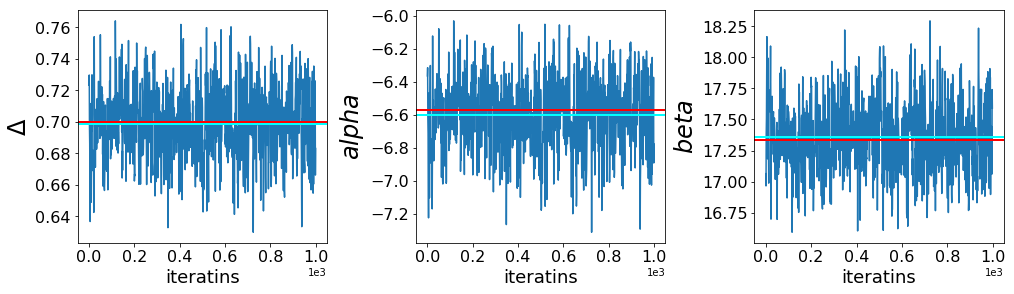

In [63]:
plt.figure(figsize=(14, 4))
for i, variables in enumerate([delta_est, alpha_est, beta_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.plot(variables)
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.axhline(y=variables.mean(), linewidth=2, color='cyan')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xlabel('iteratins', fontsize=18)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,1))
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig(os.path.join(dir_data_output,"MCMC_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"MCMC_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [64]:
eta_est=alpha_est.mean()*delta_est.mean()

J_est=beta_est.mean()*np.sqrt(delta_est.mean())


eta_est, J_est

(-4.614530336350983, 14.510063794319493)

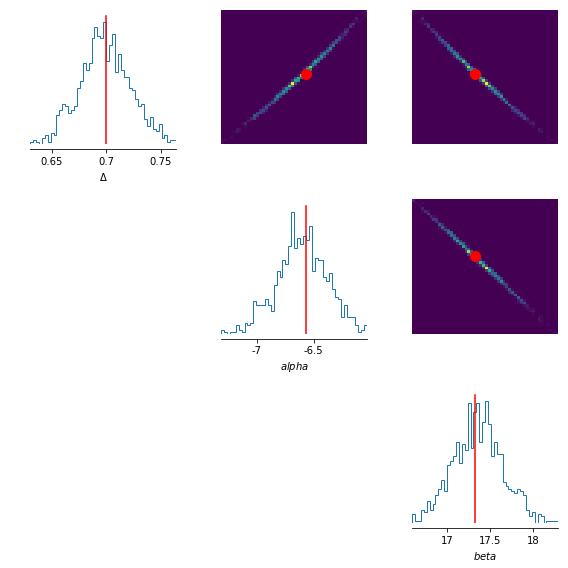

In [65]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');

plt.tight_layout();


plt.savefig(os.path.join(dir_data_output,"Pairplots_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Pairplots_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

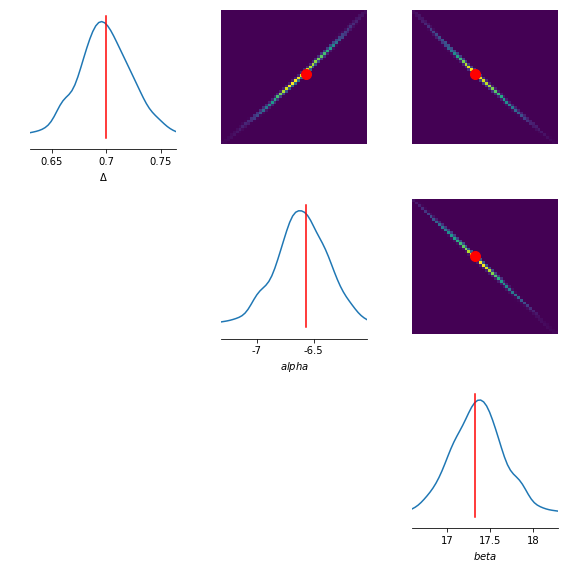

In [66]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();


plt.savefig(os.path.join(dir_data_output,"Pairplots_kde_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Pairplots_kde_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

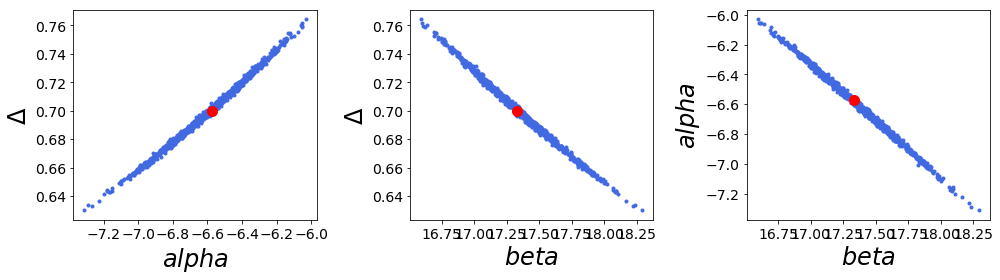

In [67]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(alpha_est, delta_est,'.', color='royalblue')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$\Delta$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(beta_est, delta_est, '.', color='royalblue')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$\Delta$",fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(beta_est, alpha_est, '.', color='royalblue')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$alpha$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Jointposteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Jointposteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

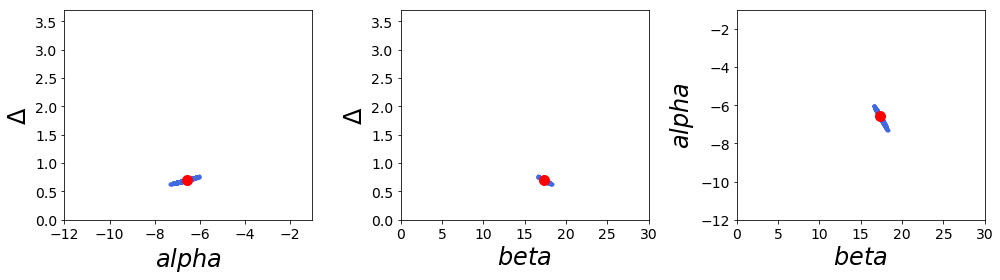

In [69]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(alpha_est, delta_est,'.', color='royalblue')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$\Delta$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-12, -1)
plt.ylim(0, 3.7)
plt.subplot(132)
plt.plot(beta_est, delta_est, '.', color='royalblue')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$\Delta$",fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 30)
plt.ylim(0, 3.7)
plt.subplot(133)
plt.plot(beta_est, alpha_est, '.', color='royalblue')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$alpha$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 30)
plt.ylim(-12, -1)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Jointposteriors_lim_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Jointposteriors_lim_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

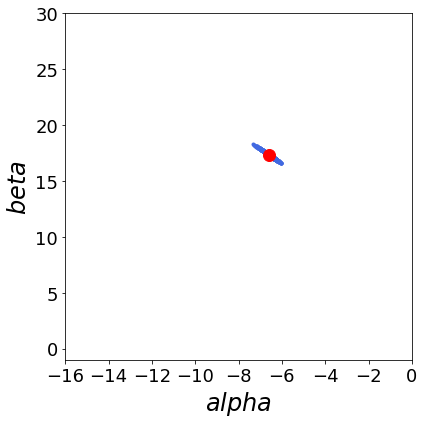

In [70]:
plt.figure(figsize=(6, 6))
plt.plot(alpha_est, beta_est, '.', color='royalblue')
plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$beta$", fontsize=24)
plt.plot(alpha_true, beta_true, 'o', color='red', markersize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-16, 0)
plt.ylim(-1, 30)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

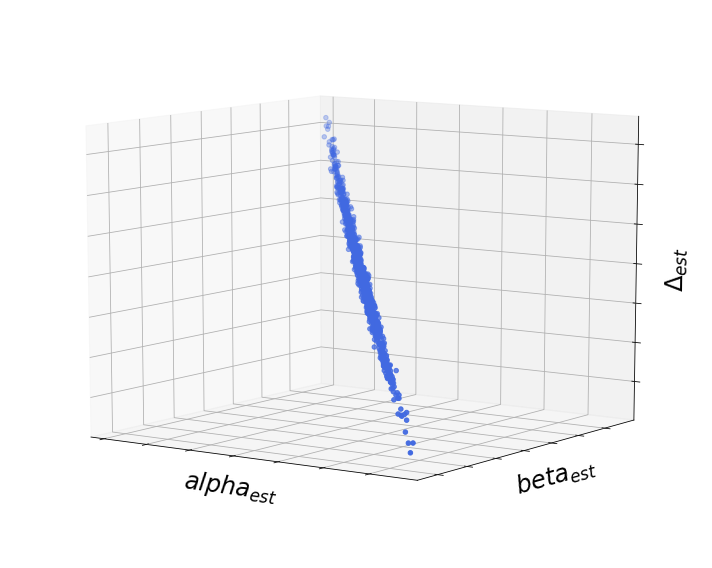

In [71]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =alpha_est
y =beta_est
z =delta_est
ax.scatter(x, y, z, c='royalblue', marker='o')
ax.set_xlabel("$alpha_{est}$", fontsize=24)
ax.set_ylabel("$beta_{est}$", fontsize=24)
ax.set_zlabel("$\Delta_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, 125)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Jointposteriors3D_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Jointposteriors3D_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [72]:
delta_est=array([delta_est]).T
alpha_est=array([alpha_est]).T
beta_est=array([beta_est]).T

In [73]:
params = {'delta': delta_est, 'alpha': alpha_est, 'beta': beta_est}
        
f=concatenate((delta_est, alpha_est, beta_est), axis=1)
df = pd.DataFrame(f, columns=['delta',  'alpha', 'beta' ])

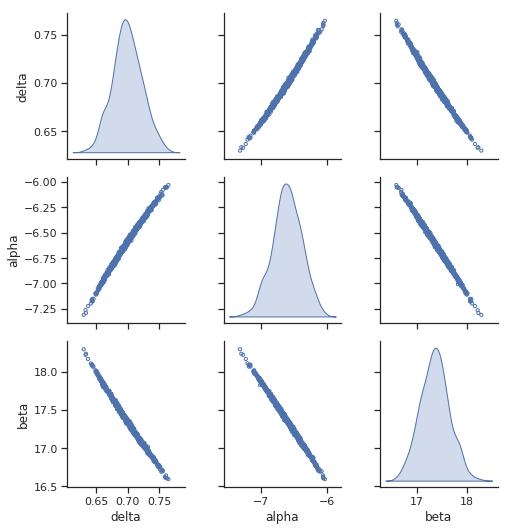

In [74]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
# g.set(xticklabels=[])
# g.set(yticklabels=[])

plt.savefig(os.path.join(dir_data_output,"Jointposteriors_pairshist_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Jointposteriors_pairshist_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)



In [75]:
df.corr()

,delta,alpha,beta
delta,1.000000,0.997310,-0.997785
alpha,0.997310,1.000000,-0.998391
beta,-0.997785,-0.998391,1.000000


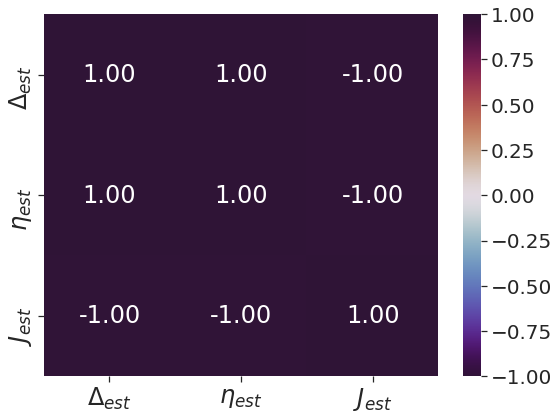

In [76]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"CorrMatrix_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"CorrMatrix_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)


plt.show()

In [77]:
parameters = [ {"delta":delta_true, "eta":eta_true, "J":J_true, "I0":0.},
               {"delta":delta_est.mean(), "eta":eta_est.mean(), "J":J_est.mean(), "I0":0.}]

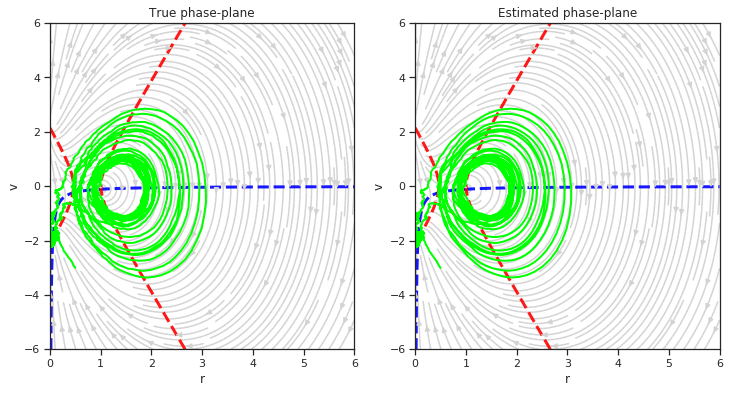

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
params_true=parameters[0]
xrange = (0, 6) 
yrange =(-6, 6)
plot_vector_field(ax[0], params_true, xrange, yrange)
ax[0].plot(rs,vs,  marker="o", markersize=0, lw=2, color='lime')
ax[0].set(xlabel='r',  title='True phase-plane')
ax[0].set(ylabel='v', )

params_est=parameters[1]
xrange = (0, 6) 
yrange =(-6, 6)
plot_vector_field(ax[1], params_est, xrange, yrange)
ax[1].plot(r_est_mean,v_est_mean,  marker="o", markersize=0, lw=2, color='lime')
ax[1].set(xlabel='r',  title='Estimated phase-plane')
ax[1].set(ylabel='v', )
plt.savefig(os.path.join(dir_data_output,"EtimatedPhasePlane_"+str(model)+"_chain_"+str(chain)+".png"))

plt.show()

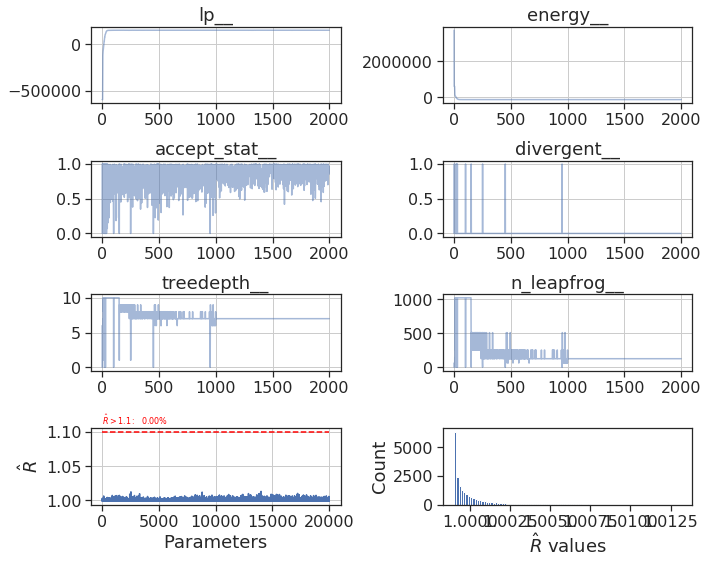

In [79]:
plt.figure(figsize=(10,8))
Nuts_plot(dict_samples_diagnostics, fit_summary)
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"NUTS_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"NUTS_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)
plt.show()

In [80]:
Burnin=0
nSample=fit['lp__'].shape[0]-Burnin

In [81]:
divergent__=fit['divergent__'][-nSample:][:,newaxis]
lp__=fit['lp__'][-nSample:][:,newaxis]
n_leapfrog__=fit['n_leapfrog__'][-nSample:][:,newaxis]

In [82]:
divergent__.shape,n_leapfrog__.shape,lp__.shape

((2000, 1), (2000, 1), (2000, 1))

In [83]:
delta_est=fit['delta'][-nSample:]
alpha_est=fit['alpha'][-nSample:]
beta_est=fit['beta'][-nSample:]

In [84]:
div_idx=fit['divergent__'].astype('int')
div_idx

array([0, 1, 1, ..., 0, 0, 0])

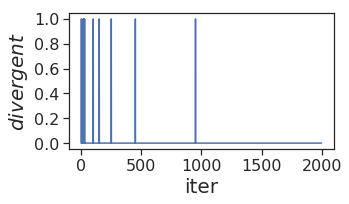

In [85]:
figure(figsize=(5, 3))
plt.plot(divergent__, 'b')
plt.xlabel('iter', fontsize=20)
plt.ylabel('$divergent$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
tight_layout()
plt.savefig(os.path.join(dir_data_output,"div_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"div_diagnostics_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [88]:
params = {'delta': delta_est, 'alpha': alpha_est, 'beta': beta_est}

In [89]:
nondiv_params = dict((key, params[key][div_idx == 0]) for key in params)
div_params =    dict((key, params[key][div_idx == 1]) for key in params)

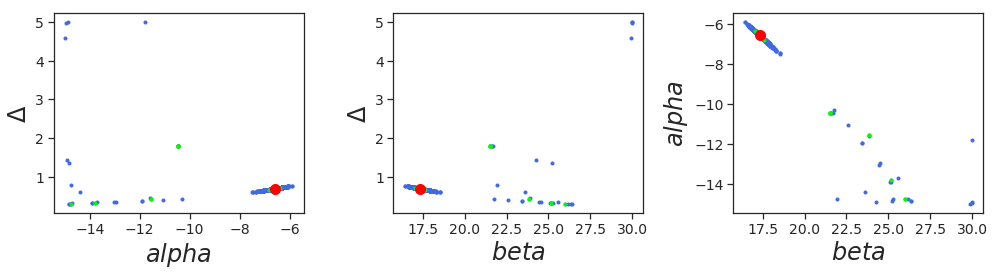

In [90]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(nondiv_params['alpha'], nondiv_params['delta'],'.', color='royalblue')
plt.plot(div_params['alpha'], div_params['delta'],'.', color='lime')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$\Delta$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(nondiv_params['beta'], nondiv_params['delta'], '.', color='royalblue')
plt.plot(div_params['beta'], div_params['delta'], '.', color='lime')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$\Delta$",fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(nondiv_params['beta'], nondiv_params['alpha'], '.', color='royalblue')
plt.plot(div_params['beta'], div_params['alpha'], '.', color='lime')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=24)
plt.ylabel("$alpha$", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

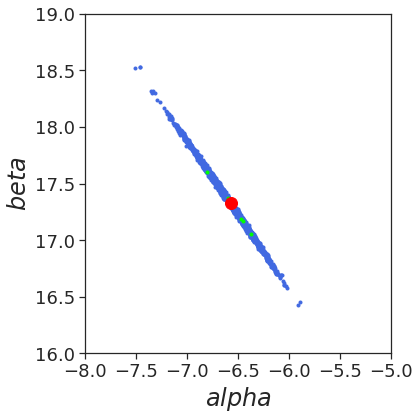

In [94]:
plt.figure(figsize=(6, 6))
plt.plot(nondiv_params['alpha'], nondiv_params['beta'], '.', color='royalblue')
plt.plot(div_params['alpha'], div_params['beta'], '.', color='lime')

plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$beta$", fontsize=24)
plt.plot(alpha_true, beta_true, 'o', color='red', markersize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-8, -5)
plt.ylim(16, 19)
plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Divs_lim_Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Divs_lim_Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

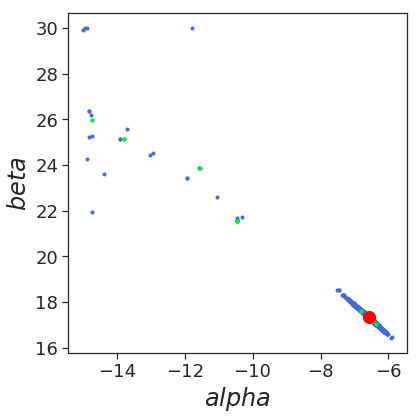

In [95]:
plt.figure(figsize=(6, 6))
plt.plot(nondiv_params['alpha'], nondiv_params['beta'], '.', color='royalblue')
plt.plot(div_params['alpha'], div_params['beta'], '.', color='lime')

plt.xlabel("$alpha$", fontsize=24)
plt.ylabel("$beta$", fontsize=24)
plt.plot(alpha_true, beta_true, 'o', color='red', markersize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors_alpha_beta_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

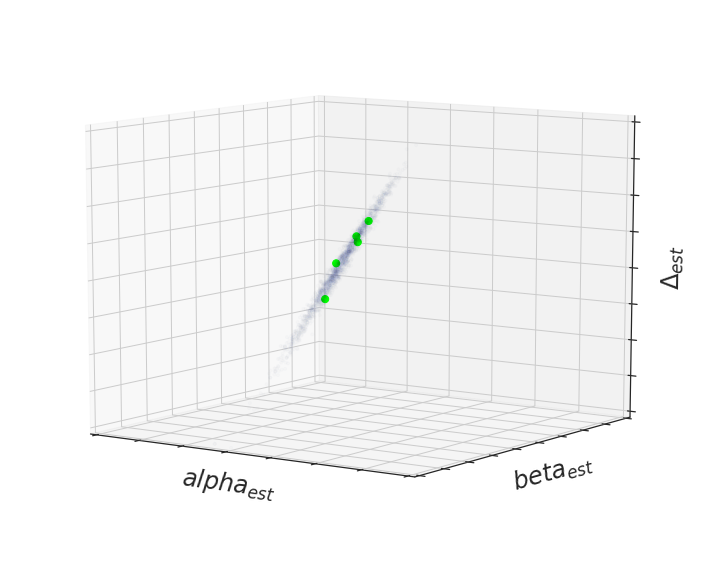

In [197]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =nondiv_params['alpha']
y =nondiv_params['beta']
z =nondiv_params['delta']
ax.scatter(x, y, z,  marker='o', s=10, facecolors='none', edgecolors='royalblue',alpha=0.01)

x =div_params['alpha']
y =div_params['beta']
z =div_params['delta']

ax.scatter(x, y, z, marker='o',  s=50, facecolors='lime', edgecolors='lime',alpha=1)
ax.set_xlim(-6.4, -5.)
ax.set_ylim(16, 16.9)
ax.set_zlim(0.4, 0.8)

ax.set_xlabel("$alpha_{est}$", fontsize=24)
ax.set_ylabel("$beta_{est}$", fontsize=24)
ax.set_zlabel("$\Delta_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(-6.4, -5.)
ax.set_ylim(16, 16.9)
ax.set_zlim(0.4, .8)
ax.view_init(10, 125)

plt.tight_layout()

plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors3D_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".png"), doi=800)
plt.savefig(os.path.join(dir_data_output,"Divs_Jointposteriors3D_MPR_NMM_HMC_SDE_raw_rv_ratios_obs1"+"_chain_"+str(chain)+".eps"), doi=800)

plt.show()

In [198]:
posterior_samples=np.array([delta_est, alpha_est, beta_est]).T
posterior_samples.shape

(2000, 3)

In [199]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_hmc_obs.npy' ) , posterior_samples)